In [2]:
import os
import sys
sys.path.append("../../NephNet")
import argparse
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from train import get_instance
import numpy as np
import torchvision
from torch.nn import functional as F
from torch import topk
import skimage.transform
from torch.optim import lr_scheduler
from tqdm import tqdm
import math
from utils import util
import pandas as pd

print("Modules loaded")

C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\tqdm\autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Modules loaded


In [14]:
print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

model_threeD = getattr(module_arch, 'threeDmodel')(num_feature=76, num_classes=9)
model_dense = getattr(module_arch, 'Dense3D')(num_feature=48, num_classes=9)

# load state dict
resume_threeD = "C:/Users/awoloshu/Documents/NephNet/saved/allF33F44Training/1211_112328/model_best.pth"
resume_dense = "C:/Users/awoloshu/Documents/NephNet/saved/weights_denseModel/model_best.pth"
checkpoint_threeD = torch.load(resume_threeD)
checkpoint_dense = torch.load(resume_dense)
model_threeD.load_state_dict(checkpoint_threeD['state_dict'])

# original saved file with DataParallel
state_dict = checkpoint_dense['state_dict']
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
model_dense.load_state_dict(new_state_dict)

models = [model_threeD, model_dense]

print("FIN")

GPUs available: 1
FIN


In [15]:
#Create a data loader for F59

data_loader = getattr(module_data, "hdf5_3d_dataloader")(
        "C:/Users/awoloshu/Desktop/datasets/F59_testing/3d_all/dataset.h5",
        batch_size=32,
        shuffle=False,
        validation_split=0.0,
        training=False,
        num_workers=0,
        projected = False,
        shape = [7,32,32],
        mean = 25.107,
        stdev = 27.243
    )

# get function handles of loss and metrics
loss_fn = getattr(module_loss, "cross_entropy_loss")
metrics= ["accuracy","f1","balanced_accuracy","precision","recall"]
metric_fns = [getattr(module_metric, met) for met in metrics]
criterion = loss_fn(None)
#criterion = loss_fn(data_loader.dataset.weight.to(device)) # for imbalanced datasets

# prepare model for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for model in models:
    model = model.to(device)
    model.eval()

total_loss = 0.0
total_metrics = torch.zeros(len(metric_fns))

#classes = ('endothelium', 'pct', 'vasculature')
classes = ('S1', 'PCT', 'TAL', 'DCT', 'CD', 'cd45', 'nestin', 'cd31_glom', 'cd31_inter')




In [33]:
outputOverlaycsv = False
all_true = []
all_softmax = []
with torch.no_grad():
    for i, (data, target) in enumerate(tqdm(data_loader)):
        k=2
        outputs = []
        data, target = data.to(device), target.to(device)
        m = torch.nn.Softmax(dim=0)
        for model in models:
            output = model(data)
            batch = []
            for row in output.cpu():
                sm = m(row)
                batch.append(sm.data.numpy())
            outputs.append(batch)
        all_softmax.extend(np.sum(np.asarray(outputs), axis=0)) #just add the softmax probabilities together
        all_true.extend(target.cpu().data.numpy())



100%|██████████| 503/503 [00:42<00:00, 11.79it/s]


In [34]:
all_softmax = np.asarray(all_softmax)
all_true = np.asarray(all_true)
print(all_softmax.shape)
print(all_true.shape)

(16070, 9)
(16070,)


In [37]:
prediction = np.argmax(all_softmax, axis = 1)
print(prediction.shape)
import sklearn.metrics as skm
balanced_acc = skm.balanced_accuracy_score(all_true, prediction)
print("Balanced accuracy = {:.2f}%".format(balanced_acc*100))

(16070,)


C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Balanced accuracy = 61.39%


../../NephNet\utils\util.py:194: RuntimeWarning: invalid value encountered in longlong_scalars
  accs.append(cm[i,i] / np.sum(row))


Calculated balanced accuracy after combining PCT: nan
Confusion matrix, without normalization
[[   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [  33    1   56   17  475   16   12  100]
 [ 394   10   97   55  116 3176  432  202]
 [ 220    1   82   17  181 1473 1593  359]
 [ 647   31  774  151  358  242   75 4674]]


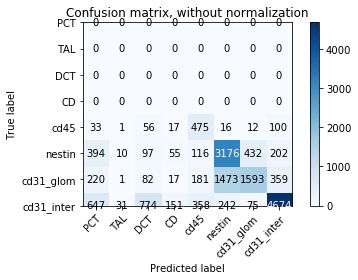

In [38]:
util.plot_confusion_matrix_combinePCT(all_true, prediction, classes=classes, normalize=False)